In [1]:
import xgboost
print(xgboost.__version__)

2.0.3


In [2]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from xgboost import XGBRegressor, plot_tree
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# Data import

In [3]:
PPGR_meal_merged = pd.read_csv('../data/PPGR_meal_merged_cont2.csv',index_col=0)

CGM_post120_col = list(PPGR_meal_merged.columns[71:96])
CGM_post240_col = list(PPGR_meal_merged.columns[71:120])

PPGR_meal_merged[CGM_post240_col] = PPGR_meal_merged.loc[:,CGM_post240_col].interpolate(axis=1)
G0 = PPGR_meal_merged['p_000']

cgm_cols = list(PPGR_meal_merged.columns[71:120])

iAUC_2h = [0]*len(PPGR_meal_merged)
for i in range(1,25):
    Gi = PPGR_meal_merged[CGM_post120_col[i]]
    Gi_1 = PPGR_meal_merged[CGM_post120_col[i-1]]
    Si = ((Gi-G0)+(Gi_1-G0))/2
    iAUC_2h+=Si*5
    
iAUC_4h = [0]*len(PPGR_meal_merged)
for i in range(1,49):
    Gi = PPGR_meal_merged[CGM_post240_col[i]]
    Gi_1 = PPGR_meal_merged[CGM_post240_col[i-1]]
    Si = ((Gi-G0)+(Gi_1-G0))/2
    iAUC_4h+=Si*5
    
    
PPGR_meal_merged['PPGR_u2'] = iAUC_2h/60
PPGR_meal_merged['PPGR_u4'] = iAUC_4h/60

In [4]:
PPGR_meal_merged_filt = PPGR_meal_merged.dropna(subset=['meal_m1'],axis=0)
#PPGR_meal_merged_filt = PPGR_meal_merged_filt[(PPGR_meal_merged_filt['meal_m1']>=-1440)]
PPGR_meal_merged_filt = PPGR_meal_merged_filt[(PPGR_meal_merged['Energy(kcal)']<2000) & (PPGR_meal_merged['Carb(g)']<250)]
PPGR_meal_merged_filt['Carb_root'] = PPGR_meal_merged_filt['Carb(g)']**(1/2)
PPGR_meal_merged_filt['Protein_root'] = PPGR_meal_merged_filt['Protein(g)']**(1/2)
PPGR_meal_merged_filt['Fat_root'] = PPGR_meal_merged_filt['Fat(g)']**(1/2)
PPGR_meal_merged_filt['Carb_pro'] = PPGR_meal_merged_filt['Carb(g)']*4 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100
PPGR_meal_merged_filt['Protein_pro'] = PPGR_meal_merged_filt['Protein(g)']*4 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100
PPGR_meal_merged_filt['Fat_pro'] = PPGR_meal_merged_filt['Fat(g)']*9 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100

OTU_data = pd.read_csv('../data/T2D_KBSMC_otu_norm.csv',index_col=0)
OTU_data = OTU_data.loc[:,list(np.sum(OTU_data>0) > len(OTU_data)*0.2)]
OTU_data_bc = pd.DataFrame(stats.boxcox(OTU_data,lmbda=0.25),columns=OTU_data.columns,index=OTU_data.index)
med_data = pd.read_excel('../data/CGM Nutrition_CRF_Medication.xlsx')
clinical_data = pd.read_excel('../data/CGM Nutrition_CRF_20230808_추가Lab.xlsx')

CGM_pre240_col = list(PPGR_meal_merged_filt.columns[23:72]) 
CGM_pre120_col = list(PPGR_meal_merged_filt.columns[47:72]) 
CGM_pre60_col = list(PPGR_meal_merged_filt.columns[59:72]) #13
CGM_pre30_col = list(PPGR_meal_merged_filt.columns[65:72]) #7
CGM_post120_col = list(PPGR_meal_merged_filt.columns[71:96])
CGM_post240_col = list(PPGR_meal_merged_filt.columns[71:120])

        
PPGR_data =  PPGR_meal_merged_filt.dropna(subset=['PPGR_u2','PPGR_u4']+CGM_pre30_col,axis=0)
PPGR = 'PPGR_u2'
PPGR_4 = 'PPGR_u4'
meal_composition = ['Carb_root','Protein(g)','Fat(g)','Energy(kcal)','Fiber(g)','Carb_pro','Protein_pro','Fat_pro']
meal_context = ['meal_m1','prot_b6h','Time']
cli_col = ['Age','DM_Duration','BMI','HbA1c','SBP','DBP','HDL','LDL','AST(IU/L)','ALT(IU/L)'] #cli_col = ['Age','DM_Duration','BMI','Weight(kg)','Waist_Circumference(cm)','SBP','DBP','FBS','HbA1c','Total_chol','HDL','LDL','MDRD_eGFR','C-peptide_index','HR(bpm)','AST(IU/L)','ALT(IU/L)']
med_col = ['Basal_Ins_Dose_Unit','MFM_Dose_Total','SU_Dose_Total','DPP4i_Dose_Total','SGLT2i_Dose_Total'] #med_col = ['Basal_Ins_Dose_Unit','GLP1_Dose_Total','MFM_Dose_Total','SU_Dose_Total','DPP4i_Dose_Total','SGLT2i_Dose_Total','TZD_Dose_Total']

microbiome_col = list(pd.read_csv('../features/filter_p0.05_367.csv')['feature'])
OTU_data_bc = OTU_data_bc[microbiome_col]
microbiome_col_ = [';'.join(var.split(';')[-2:]) for var in microbiome_col]
OTU_data_bc.columns = microbiome_col_

full_data = pd.merge(PPGR_data[['ID',PPGR,PPGR_4]+CGM_pre240_col+CGM_post240_col+meal_composition+meal_context],OTU_data_bc,left_on='ID',right_index=True)
full_data = full_data.T.drop_duplicates().T
full_data = pd.merge(full_data,med_data,how='left',on='ID')
full_data = pd.merge(full_data,clinical_data,how='left',on='ID')
full_data[PPGR] = full_data[PPGR].astype(float)
full_data[PPGR_4] = full_data[PPGR_4].astype(float)
full_data[meal_composition+meal_context+cli_col+med_col+microbiome_col_+CGM_pre240_col] = full_data[meal_composition+meal_context+cli_col+med_col+microbiome_col_+CGM_pre240_col].astype(float)

samples = list(full_data['ID'].unique())

full_data

C:\Users\jkw20\AppData\Local\Temp\ipykernel_24220\2582215583.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PPGR_meal_merged_filt = PPGR_meal_merged_filt[(PPGR_meal_merged['Energy(kcal)']<2000) & (PPGR_meal_merged['Carb(g)']<250)]
C:\Users\jkw20\anaconda3\envs\AI\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,ID,PPGR_u2,PPGR_u4,m_240,m_235,m_230,m_225,m_220,m_215,m_210,...,TG,HDL,LDL,MDRD_eGFR,C_pep,C-peptide_index,HOMA IR (C-peptide),HR(bpm),AST(IU/L),ALT(IU/L)
0,R01,114.625000,244.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,315,32.0,44.0,86.1,1.7,4.612802,0.192700,91.5,24.0,39.0
1,R01,26.666667,-24.791667,147.0,147.0,145.0,143.0,141.0,139.0,138.0,...,315,32.0,44.0,86.1,1.7,4.612802,0.192700,91.5,24.0,39.0
2,R01,141.750000,217.750000,158.0,163.0,169.0,177.0,185.0,193.0,199.0,...,315,32.0,44.0,86.1,1.7,4.612802,0.192700,91.5,24.0,39.0
3,R01,208.458333,414.458333,137.0,136.0,135.0,134.0,133.0,132.0,130.0,...,315,32.0,44.0,86.1,1.7,4.612802,0.192700,91.5,24.0,39.0
4,R01,168.083333,193.666667,112.0,112.0,113.0,114.0,117.0,119.0,121.0,...,315,32.0,44.0,86.1,1.7,4.612802,0.192700,91.5,24.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,R50,60.583333,169.875000,267.0,270.0,271.0,272.0,272.0,271.0,271.0,...,155,45.0,68.0,107.7,1.2,5.432546,0.163623,94.0,19.0,21.0
907,R50,24.458333,116.250000,192.0,197.0,201.0,205.0,209.0,213.0,217.0,...,155,45.0,68.0,107.7,1.2,5.432546,0.163623,94.0,19.0,21.0
908,R50,-4.875000,217.458333,142.0,143.0,143.0,144.0,145.0,146.0,147.0,...,155,45.0,68.0,107.7,1.2,5.432546,0.163623,94.0,19.0,21.0
909,R50,-40.250000,-61.000000,173.0,181.0,191.0,204.0,216.0,228.0,240.0,...,155,45.0,68.0,107.7,1.2,5.432546,0.163623,94.0,19.0,21.0


In [5]:
evaluation_data = pd.read_csv('../data/validation/PPGR_meal_merged_validation.csv',index_col=0)
evaluation_data = evaluation_data.rename(columns = dict(zip(microbiome_col,microbiome_col_)))
evaluation_data

,ID,PPGR_u2,PPGR_u4,Carb(g),Meal,m_240,m_235,m_230,m_225,m_220,...,Bacteria;Fusobacteria;Fusobacteria_c;Fusobacteriales;Fusobacteriaceae;Fusobacterium;Fusobacterium_necrogenes_group,Bacteria;Actinobacteria;Coriobacteriia;Coriobacteriales;Coriobacteriaceae;Slackia;Slackia_isoflavoniconvertens,Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;NHOC_g;PAC001240_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Anaerotignum;PAC002392_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;Sporobacter;EU779114_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;PAC000195_g;DQ801499_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Acetitomaculum;PAC001448_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Coprococcus_g2;EF640143_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Christensenellaceae;PAC001207_g;PAC002323_s,Bacteria;Firmicutes;Clostridia;Natranaerobiales;Dethiobacter_f;EF585983_g;EF585983_g_uc
0,C0001,-37.500000,10.458333,10.00,5.0,130.0,128.0,129.0,126.0,123.0,...,-4.0,-4.0,-4.00000,-4.0,-4.0,-4.000000,-4.0,-4.0,-4.0,-4.0
1,C0001,-38.583333,-135.500000,77.00,3.0,179.0,175.0,167.0,160.0,159.0,...,-4.0,-4.0,-4.00000,-4.0,-4.0,-4.000000,-4.0,-4.0,-4.0,-4.0
2,C0001,121.250000,177.416667,50.45,1.0,84.0,82.0,78.0,75.0,73.0,...,-4.0,-4.0,-4.00000,-4.0,-4.0,-4.000000,-4.0,-4.0,-4.0,-4.0
3,C0001,103.333333,368.458333,97.08,2.0,99.0,103.0,102.0,99.0,98.0,...,-4.0,-4.0,-4.00000,-4.0,-4.0,-4.000000,-4.0,-4.0,-4.0,-4.0
4,C0001,64.458333,195.875000,3.66,3.0,246.0,253.0,253.0,255.0,257.0,...,-4.0,-4.0,-4.00000,-4.0,-4.0,-4.000000,-4.0,-4.0,-4.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,C0051,35.291667,49.250000,83.15,1.0,122.0,125.0,128.0,124.0,124.0,...,-4.0,-4.0,-2.85875,-4.0,-4.0,-3.645982,-4.0,-4.0,-4.0,-4.0
1244,C0051,80.750000,154.000000,72.79,2.0,130.0,130.0,140.0,148.0,151.0,...,-4.0,-4.0,-2.85875,-4.0,-4.0,-3.645982,-4.0,-4.0,-4.0,-4.0
1245,C0051,-30.875000,-93.125000,14.10,3.0,201.0,198.0,197.0,194.0,191.0,...,-4.0,-4.0,-2.85875,-4.0,-4.0,-3.645982,-4.0,-4.0,-4.0,-4.0
1246,C0051,54.125000,112.833333,21.94,5.0,169.0,175.0,174.0,169.0,166.0,...,-4.0,-4.0,-2.85875,-4.0,-4.0,-3.645982,-4.0,-4.0,-4.0,-4.0


# CGM measurement calculation
iAUCb240 – Incremental AUC 240 minutes before the meal start (mmol/L*hour)

iAUCb120 – Incremental AUC 120 minutes before the meal start (mmol/L*hour)

iAUCb60 – Incremental AUC 60 minutes before the meal start (mmol/L*hour)

BGRiseb240 – BG rise from 240 minutes before the meal to meal start (mmol/L)

BGRiseb120 – BG rise from 120 minutes before the meal to meal start (mmol/L)

BGRiseb60 – BG rise from 60 minutes before the meal to meal start (mmol/L)

BGTrend240 – BG trend 4 hours before the meal start (mmol/L)

BGTrend120 – BG trend 2 hours before the meal start (mmol/L)

BGTrend60 – BG trend 1 hour before the meal start (mmol/L)

In [7]:
def iAUC(data):
# iAUCb240, 120, 60
    G_240 = data['m_240']
    G_120 = data['m_120']
    G_60 = data['m_060']
    G0 = data['p_000']
    
    iAUCb240 = [0]*len(data)
    for i in range(1,49):
        Gi = data[CGM_pre240_col[i]]
        Gi_1 = data[CGM_pre240_col[i-1]]
        Si = ((Gi-G_240)+(Gi_1-G_240))/2
        iAUCb240+=Si
        
    iAUCb120 = [0]*len(data)
    for i in range(1,25):
        Gi = data[CGM_pre120_col[i]]
        Gi_1 = data[CGM_pre120_col[i-1]]
        Si = ((Gi-G_120)+(Gi_1-G_120))/2
        iAUCb120+=Si
        
    iAUCb60 = [0]*len(data)
    for i in range(1,13):
        Gi = data[CGM_pre60_col[i]]
        Gi_1 = data[CGM_pre60_col[i-1]]
        Si = ((Gi-G_60)+(Gi_1-G_60))/2
        iAUCb60+=Si
        
    data['iAUCb240'] = iAUCb240/24
    data['iAUCb120'] = iAUCb120.astype(float)/12
    data['iAUCb60'] = iAUCb60.astype(float)/6
    return data
full_data = iAUC(full_data)
evaluation_data = iAUC(evaluation_data)

C:\Users\jkw20\AppData\Local\Temp\ipykernel_9836\173037024.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['iAUCb240'] = iAUCb240/24
C:\Users\jkw20\AppData\Local\Temp\ipykernel_9836\173037024.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['iAUCb120'] = iAUCb120.astype(float)/12
C:\Users\jkw20\AppData\Local\Temp\ipykernel_9836\173037024.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

In [316]:
def BGrise(data):
    G_240 = data['m_240']
    G_120 = data['m_120']
    G_60 = data['m_060']
    G0 = data['p_000']
    # BGrise240, 120, 60
    BGrise240 = G0-G_240
    BGrise120 = G0-G_120
    BGrise60 = G0-G_60
    
    data['BGrise240'] = BGrise240
    data['BGrise120'] = BGrise120
    data['BGrise60'] = BGrise60
    return data

full_data = BGrise(full_data)
evaluation_data = BGrise(evaluation_data)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [317]:
def BGtrend(data):
    G_240 = data['m_240']
    G_120 = data['m_120']
    G_60 = data['m_060']
    G0 = data['p_000']
    # BGtrend240, 120, 60
    BGtrend240 = data['m_235'] - G_240
    BGtrend120 = data['m_115'] - G_120
    BGtrend60 = data['m_055'] - G_60
    
    data['BGtrend240'] = BGtrend240
    data['BGtrend120'] = BGtrend120
    data['BGtrend60'] = BGtrend60
    return data

full_data = BGtrend(full_data)
evaluation_data = BGtrend(evaluation_data)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [318]:
CGM_measurement = ['iAUCb240','iAUCb120','iAUCb60','BGrise240','BGrise120','BGrise60','BGtrend240','BGtrend120','BGtrend60']

# Leave-one-person-out cross validation

In [51]:
def LOOCV(data,features,n_estimators=1000,max_depth=40, model='XGB'):
    predicted_list = []
    actual_list = []
    R_list = []
    
    for sample in samples:
        train = full_data[full_data['ID']!=sample]
        val = full_data[full_data['ID']==sample]

        x_train = train[features]
        x_val = val[features]
        train_ppgr = np.array(train[PPGR_4])
        val_ppgr = np.array(val[PPGR_4])

        print(f"Leave {sample} out validation start")
        if model =='XGB':
            model = XGBRegressor(n_estimators=n_estimators,eta=0.005,max_depth=max_depth,random_state=2,reg_lambda = 1, reg_alpha=1e-05,subsample=0.3)
        else:
            model = model
        model.fit(x_train,train_ppgr)

        pred_y = model.predict(x_val)
        predicted_list.append(pred_y)
        actual_list.append(val_ppgr)

        r, p = stats.pearsonr(val_ppgr, pred_y)
        R_list.append(r)

        print(f"Leave {sample} out validation is done. The PCC is {np.round(r,3)}")
        
        predicted_ls = [v for y in predicted_list for v in y.tolist()]
        actual_ls = [v for y in actual_list for v in y]
        r, p = stats.pearsonr(predicted_ls, actual_ls)
        print(f"So far, R is {np.round(r,3)}")
        
    return predicted_list,actual_list
    
def LOOCV_vis2(predicted_list,actual_list,model):
    predicted_ls = [v for y in predicted_list for v in y.tolist()]
    actual_ls = [v for y in actual_list for v in y]
    abs_error = np.abs([predicted_ls[i] - actual_ls[i] for i in range(len(predicted_ls))])
        
    guideline = np.linspace(-500,800,10)
    plt.figure(figsize=(5,3))
    plt.scatter(y=predicted_ls,x=actual_ls,alpha=0.8,c=abs_error,cmap='coolwarm',s=7,vmin=0,vmax=650)#color='gray'
    cbar = plt.colorbar()
    cbar.set_label('Absolute error (mg/dl•h)', rotation=90)
    res = stats.pearsonr(predicted_ls, actual_ls)
    plt.plot(guideline,guideline,'--',lw=1,color='gray')

    plt.ylabel(f'Predicted PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.xlabel(f'Measured PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.xlim(np.min(actual_ls)-30,np.max(actual_ls)+30)
    #plt.ylim(-100,300)
    plt.ylim(-300,480)
    
    ymin, ymax = plt.gca().get_ylim()
    plt.text(np.min(actual_ls),ymin+(ymax-ymin)*9/10,f'R={np.round(res[0],3)}',fontsize=12)
    plt.text(np.min(actual_ls),ymin+(ymax-ymin)*8.5/10,'p=%.2e'%res[1],fontsize=10)

    plt.ylabel(f'Predicted PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.xlabel(f'Measured PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.title(f'XGB model{model} LOOCV',fontsize=10)
    plt.savefig(f"../figure/main_cohort_XGB_model{model}.jpeg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    plt.show()

def Evaluation_vis(predicted,actual,model):
    plt.style.use(['default']) 
    abs_error = np.abs(predicted-actual)
    
    guideline = np.linspace(-500,800,10)
    plt.figure(figsize=(5,3))
    plt.scatter(y=predicted,x=actual,alpha=0.7,c=abs_error,cmap='coolwarm',s=7,vmin=0,vmax=650)#color='gray'
    cbar = plt.colorbar()
    cbar.set_label('Absolute error (mg/dl•h)', rotation=90)
    res = stats.pearsonr(predicted, actual)
    plt.plot(guideline,guideline,'--',lw=1,color='gray')

    plt.ylabel(f'Predicted PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.xlabel(f'Measured PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.xlim(np.min(actual)-30,np.max(actual)+30)
    #plt.ylim(-50,200)
    plt.ylim(-300,480)
    
    ymin, ymax = plt.gca().get_ylim()
    plt.text(np.min(actual),ymin+(ymax-ymin)*9/10,f'R={np.round(res[0],3)}',fontsize=12)
    plt.text(np.min(actual),ymin+(ymax-ymin)*8.5/10,'p=%.2e'%res[1],fontsize=10)

    plt.title(f'XGB model{model} on evaluation cohort',fontsize=10)
    plt.savefig(f"../figure/evaluation_cohort_XGB_model{model}.jpeg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    plt.show()

In [7]:
mae = MeanAbsoluteError()
mse = MeanSquaredError()

# Carbohydrate only predictor (linear regression)

In [340]:
carbohydrate_only_predictor = LinearRegression()

carbo_only_predicted, actual = LOOCV(features=['Carb_root'],data=full_data,model = carbohydrate_only_predictor)

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.601
So far, R is 0.601
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.567
So far, R is 0.568
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.389
So far, R is 0.517
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.272
So far, R is 0.461
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.48
So far, R is 0.387
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.599
So far, R is 0.403
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.267
So far, R is 0.394
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.42
So far, R is 0.396
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.258
So far, R is 0.379
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.557
So far, R i

In [341]:
predicted_ls = [v for y in carbo_only_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]
abs_error = np.abs([predicted_ls[i] - actual_ls[i] for i in range(len(predicted_ls))])
baseline_error_median_main = np.quantile(abs_error,0.5)
baseline_error_median_main

117.62647461691719

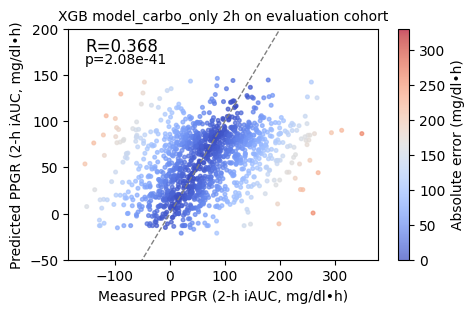

The evaluation PCC is 0.368


In [12]:
carbohydrate_only_predictor = LinearRegression()

x_train = full_data[['Carb_root']]
x_val = evaluation_data[['Carb_root']]
train_ppgr = np.array(full_data[PPGR])
val_ppgr = np.array(evaluation_data[PPGR])

carbohydrate_only_predictor.fit(x_train,train_ppgr)

pred_y = carbohydrate_only_predictor.predict(x_val)
Evaluation_vis(pred_y,val_ppgr,'_carbo_only 2h')
r, p = stats.pearsonr(val_ppgr, pred_y)

print(f"The evaluation PCC is {np.round(r,3)}")
abs_error = np.abs([pred_y[i] - val_ppgr[i] for i in range(len(pred_y))])
baseline_error_median_eval = np.quantile(abs_error,0.5)

# Model1 : Meal composition

In [52]:
model1_predicted,actual = LOOCV(full_data,meal_composition,300,3)

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.458
So far, R is 0.458
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.523
So far, R is 0.471
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.343
So far, R is 0.376
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.18
So far, R is 0.327
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.47
So far, R is 0.309
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.507
So far, R is 0.337
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.442
So far, R is 0.34
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.341
So far, R is 0.341
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.013
So far, R is 0.313
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.444
So far, R is

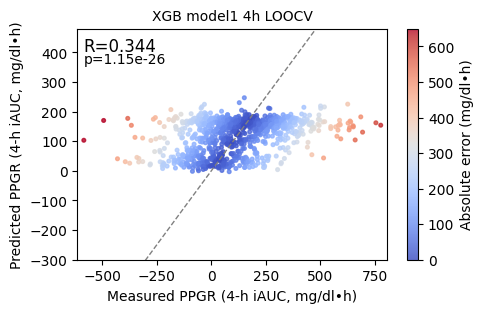

In [53]:
LOOCV_vis2(model1_predicted,actual,'1 4h')

In [17]:
predicted_ls = [v for y in model1_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 76.95560875747577
MAE: 59.44847194041866


## Evaluation

 The evaluation PCC is 0.317


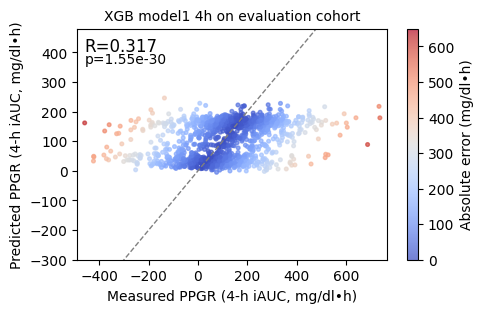

RMSE: 158.04861593434975
MAE: 120.46181038264022


In [55]:
x_train = full_data[meal_composition]
x_val = evaluation_data[meal_composition]
train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

model = XGBRegressor(n_estimators=300,eta=0.005,max_depth=3,random_state=2,reg_lambda = 1, reg_alpha=1e-05,subsample=0.3)
model.fit(x_train,train_ppgr)
pred_y = model.predict(x_val)

r, p = stats.pearsonr(val_ppgr, pred_y)

print(f" The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y,val_ppgr,'1 4h')
print('RMSE:',mse(pred_y,val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y,val_ppgr).numpy())

# Model 2: Meal composition + Meal context

In [56]:
model2_predicted,actual = LOOCV(full_data,meal_composition+meal_context,500,3) # best 1000,5

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.339
So far, R is 0.339
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.606
So far, R is 0.511
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.587
So far, R is 0.475
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.385
So far, R is 0.451
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.731
So far, R is 0.477
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.396
So far, R is 0.469
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.537
So far, R is 0.474
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.361
So far, R is 0.467
Leave R09 out validation start
Leave R09 out validation is done. The PCC is -0.348
So far, R is 0.417
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.51
So far, R

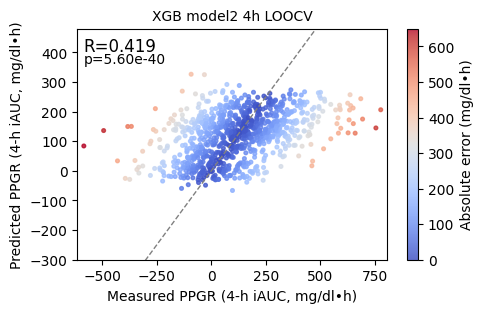

In [57]:
LOOCV_vis2(model2_predicted,actual,'2 4h')

In [21]:
predicted_ls = [v for y in model2_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 71.70320063776167
MAE: 55.411109884671305


## Evaluation

 The evaluation PCC is 0.328


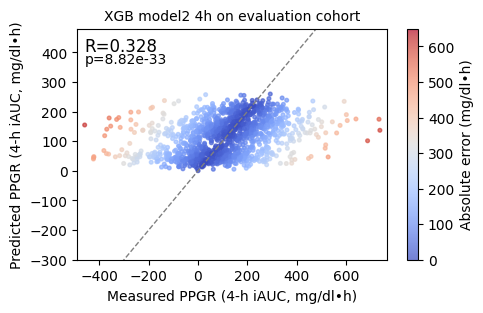

RMSE: 157.27209394867043
MAE: 118.50464664743494


In [58]:
x_train = full_data[meal_composition+meal_context]
x_val = evaluation_data[meal_composition+meal_context]
train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

model = XGBRegressor(n_estimators=300,eta=0.005,max_depth=3,random_state=2,reg_lambda = 1, reg_alpha=1e-05,subsample=0.3)
model.fit(x_train,train_ppgr)
pred_y = model.predict(x_val)

r, p = stats.pearsonr(val_ppgr, pred_y)

print(f" The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y,val_ppgr,'2 4h')
print('RMSE:',mse(pred_y,val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y,val_ppgr).numpy())

# Model3: Meal composition + Meal context + CGM

In [59]:
model3_predicted,actual = LOOCV(full_data,meal_composition+meal_context+CGM_pre30_col,500,3) # best 2000 5

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.654
So far, R is 0.654
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.814
So far, R is 0.766
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.71
So far, R is 0.741
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.865
So far, R is 0.767
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.801
So far, R is 0.707
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.77
So far, R is 0.69
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.805
So far, R is 0.692
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.376
So far, R is 0.68
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.354
So far, R is 0.666
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.68
So far, R is 0

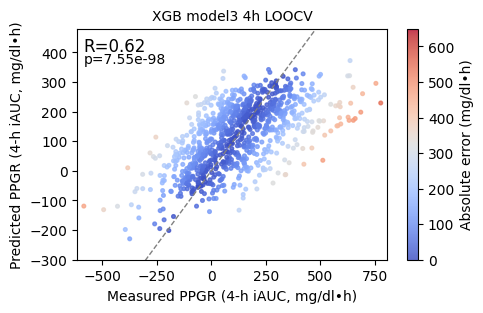

In [60]:
LOOCV_vis2(model3_predicted,actual,'3 4h')

In [25]:
predicted_ls = [v for y in model3_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 66.5263974691808
MAE: 51.3071781243765


## Evaluation

 The evaluation PCC is 0.638


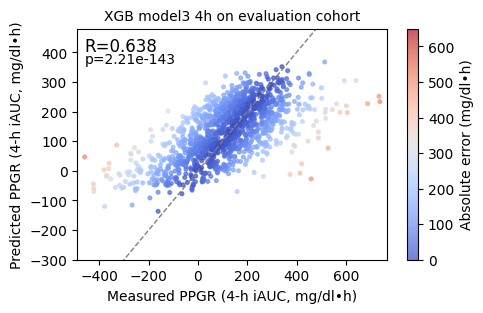

RMSE: 130.569152005535
MAE: 101.20018020941492


In [61]:
x_train = full_data[meal_composition+meal_context+CGM_pre30_col]
x_val = evaluation_data[meal_composition+meal_context+CGM_pre30_col]
train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

model = XGBRegressor(n_estimators=500,eta=0.005,max_depth=3,random_state=2,reg_lambda = 1, reg_alpha=1e-05,subsample=0.3)
model.fit(x_train,train_ppgr)
pred_y = model.predict(x_val)

r, p = stats.pearsonr(val_ppgr, pred_y)

print(f" The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y,val_ppgr,'3 4h')
print('RMSE:',mse(pred_y,val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y,val_ppgr).numpy())

# Model4: Meal composition + Meal context + CGM + clinical

In [62]:
model4_predicted,actual = LOOCV(full_data,meal_composition+meal_context+CGM_pre30_col+cli_col,600,3) # best 2000 5

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.606
So far, R is 0.606
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.822
So far, R is 0.757
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.729
So far, R is 0.72
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.864
So far, R is 0.745
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.79
So far, R is 0.703
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.742
So far, R is 0.681
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.803
So far, R is 0.678
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.382
So far, R is 0.673
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.383
So far, R is 0.668
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.658
So far, R i

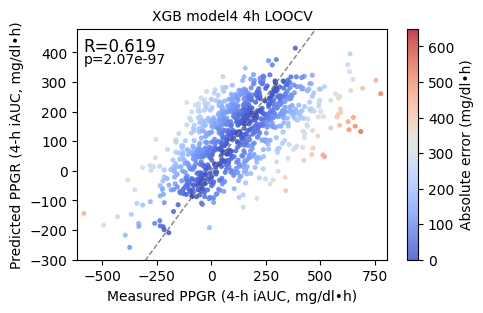

In [63]:
LOOCV_vis2(model4_predicted,actual,'4 4h')

In [375]:
predicted_ls = [v for y in model4_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 153.1614066499665
MAE: 120.62839977833059


## Evaluation

 The evaluation PCC is 0.647


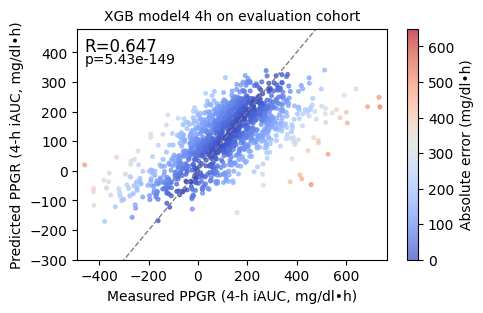

RMSE: 127.4262393924307
MAE: 98.12862961400202


In [64]:
x_train = full_data[meal_composition+meal_context+CGM_pre30_col+cli_col]
x_val = evaluation_data[meal_composition+meal_context+CGM_pre30_col+cli_col]
train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

model = XGBRegressor(n_estimators=600,eta=0.005,max_depth=3,random_state=2,reg_lambda = 1, reg_alpha=1e-05,subsample=0.3)
model.fit(x_train,train_ppgr)
pred_y = model.predict(x_val)

r, p = stats.pearsonr(val_ppgr, pred_y)

print(f" The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y,val_ppgr,'4 4h')
print('RMSE:',mse(pred_y,val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y,val_ppgr).numpy())

# Model5: Meal composition + Meal context + CGM + microbiome

In [65]:
model5_predicted,actual = LOOCV(full_data,meal_composition+meal_context+CGM_pre30_col+microbiome_col_,1000,3) # best 2000 5

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.669
So far, R is 0.669
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.833
So far, R is 0.775
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.707
So far, R is 0.747
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.846
So far, R is 0.76
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.791
So far, R is 0.723
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.777
So far, R is 0.708
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.813
So far, R is 0.694
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.395
So far, R is 0.689
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.262
So far, R is 0.679
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.705
So far, R 

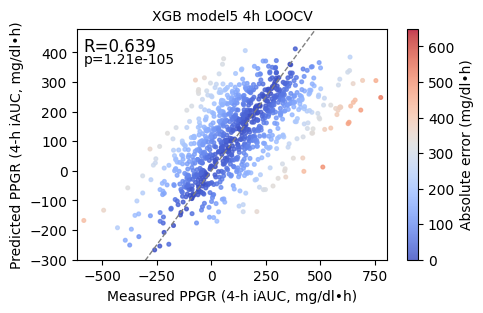

In [66]:
LOOCV_vis2(model5_predicted,actual,'5 4h')

In [381]:
predicted_ls = [v for y in model5_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 150.01361352983432
MAE: 116.63909978224078


## Evaluation

 The evaluation PCC is 0.651


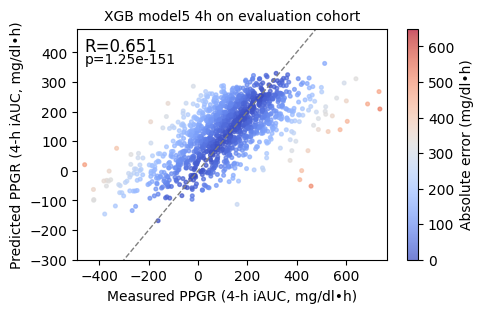

RMSE: 129.24221688102048
MAE: 100.62435178625051


In [67]:
x_train = full_data[meal_composition+meal_context+CGM_pre30_col+microbiome_col_]
x_val = evaluation_data[meal_composition+meal_context+CGM_pre30_col+microbiome_col_]
train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

model = XGBRegressor(n_estimators=600,eta=0.005,max_depth=3,random_state=2,reg_lambda = 1, reg_alpha=1e-05,subsample=0.3)
model.fit(x_train,train_ppgr)
pred_y = model.predict(x_val)

r, p = stats.pearsonr(val_ppgr, pred_y)

print(f" The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y,val_ppgr,'5 4h')
print('RMSE:',mse(pred_y,val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y,val_ppgr).numpy())

# Model6: Meal composition + Meal context + CGM + medication

In [68]:
model6_predicted,actual = LOOCV(full_data,meal_composition+meal_context+CGM_pre30_col+med_col,1000,3)

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.7
So far, R is 0.7
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.822
So far, R is 0.791
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.704
So far, R is 0.775
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.879
So far, R is 0.798
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.801
So far, R is 0.769
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.787
So far, R is 0.744
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.804
So far, R is 0.743
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.343
So far, R is 0.731
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.307
So far, R is 0.724
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.665
So far, R is 

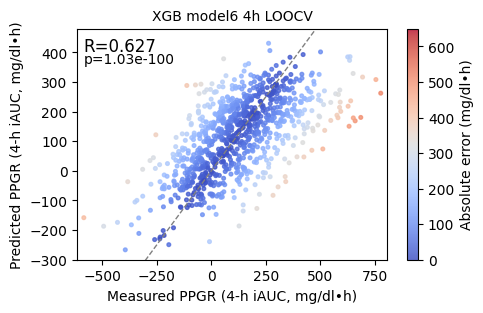

In [69]:
LOOCV_vis2(model6_predicted,actual,'6 4h')

In [400]:
predicted_ls = [v for y in model6_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 151.84703419886952
MAE: 119.22204632847205


## Evaluation

 The evaluation PCC is 0.641


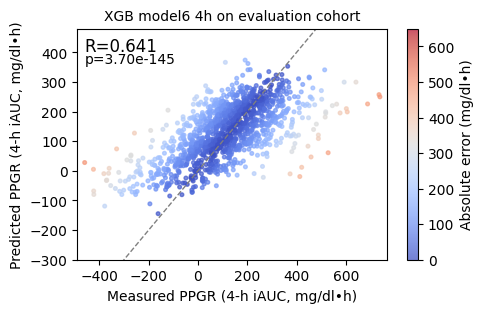

RMSE: 130.066165552047
MAE: 100.38936387144552


In [70]:
x_train = full_data[meal_composition+meal_context+CGM_pre30_col+med_col]
x_val = evaluation_data[meal_composition+meal_context+CGM_pre30_col+med_col]
train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

model = XGBRegressor(n_estimators=500,eta=0.005,max_depth=3,random_state=2,reg_lambda = 1, reg_alpha=1e-05,subsample=0.3)
model.fit(x_train,train_ppgr)
pred_y = model.predict(x_val)

r, p = stats.pearsonr(val_ppgr, pred_y)

print(f" The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y,val_ppgr,'6 4h')
print('RMSE:',mse(pred_y,val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y,val_ppgr).numpy())

# Model7: Meal composition + Meal context + CGM + clinical + microbiome + medication

In [71]:
model7_predicted,actual = LOOCV(full_data,meal_composition+meal_context+CGM_pre30_col+ cli_col+ microbiome_col_ + med_col, 1000,3) # best 1000 5

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.657
So far, R is 0.657
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.835
So far, R is 0.782
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.711
So far, R is 0.752
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.847
So far, R is 0.777
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.795
So far, R is 0.75
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.779
So far, R is 0.734
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.813
So far, R is 0.723
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.39
So far, R is 0.717
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.38
So far, R is 0.714
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.715
So far, R is

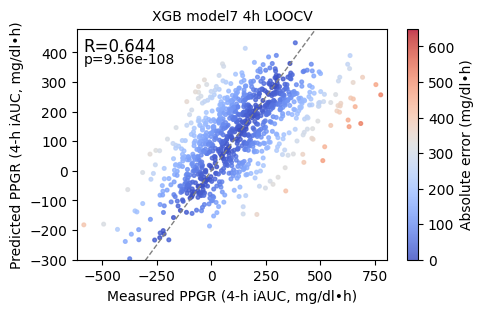

In [72]:
LOOCV_vis2(model7_predicted,actual,'7 4h')

In [73]:
predicted_ls = [v for y in model7_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 149.21152536486923
MAE: 116.52419893221676


## Evaluation

 The evaluation PCC is 0.652


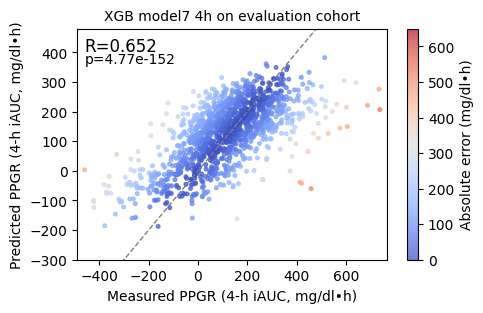

RMSE: 127.24874409992545
MAE: 98.88221395928929


In [74]:
x_train = full_data[meal_composition+meal_context+CGM_pre30_col+cli_col+microbiome_col_+med_col]#CGM_measurement+
x_val = evaluation_data[meal_composition+meal_context+CGM_pre30_col+cli_col+microbiome_col_+med_col]#CGM_measurement
train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

model = XGBRegressor(n_estimators=600,eta=0.007,max_depth=3,random_state=2,reg_lambda = 1, reg_alpha=1,subsample=0.3)
model.fit(x_train,train_ppgr)
pred_y = model.predict(x_val)

r, p = stats.pearsonr(val_ppgr, pred_y)

print(f" The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y,val_ppgr,'7 4h')
print('RMSE:',mse(pred_y,val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y,val_ppgr).numpy())

# XAI of XGB

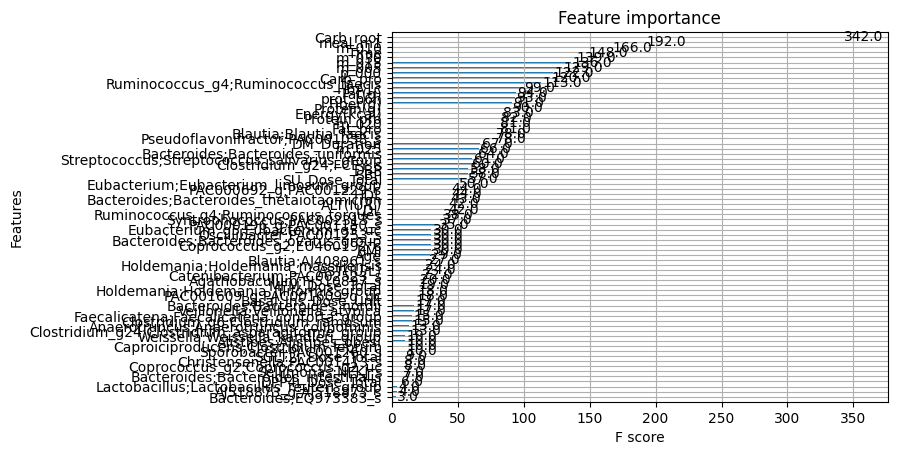

In [525]:
from xgboost import plot_importance

plot_importance(model)
plt.show()

# SHAP

In [526]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(evaluation_data[meal_composition+meal_context+CGM_pre30_col+ cli_col+ microbiome_col_ + med_col])

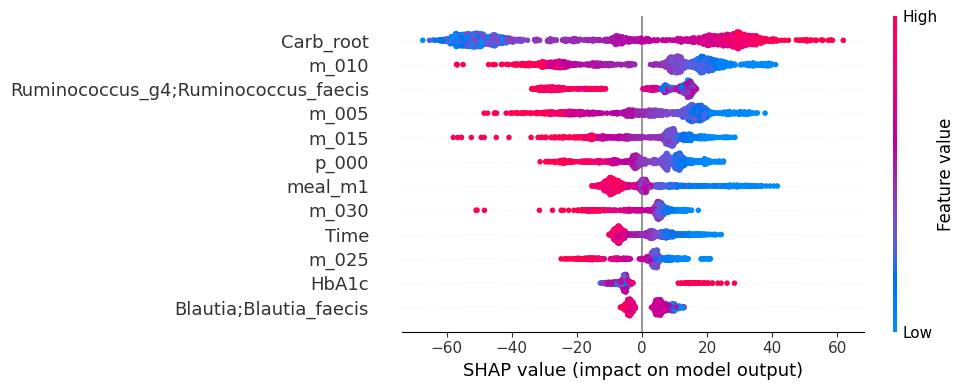

In [527]:
shap.summary_plot(shap_values,evaluation_data[meal_composition+meal_context+CGM_pre30_col+ cli_col+ microbiome_col_ + med_col],plot_size=(10,4),max_display=12)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


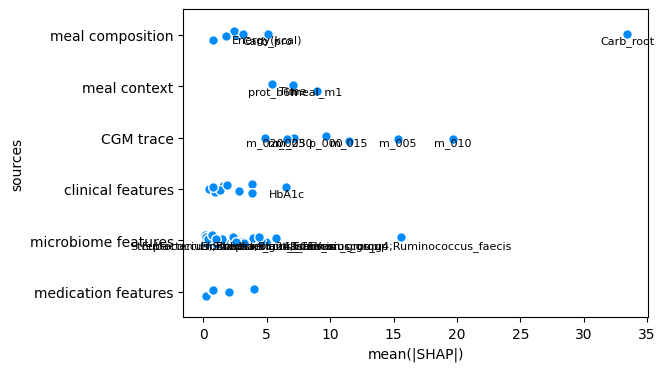

In [528]:
shap_values_mean=np.abs(shap_values).mean(axis=0)
all_cols = meal_composition+meal_context+CGM_pre30_col+cli_col+microbiome_col_+med_col
sources = ['meal composition']*len(meal_composition)+['meal context']*len(meal_context)+['CGM trace']*len(CGM_pre30_col)+ ['clinical features']*len(cli_col)+ ['microbiome features']*len(microbiome_col_) + ['medication features']*len(med_col)
tmp = pd.DataFrame({'mean(|SHAP|)':shap_values_mean,'feature':all_cols,'sources':sources})
plt.figure(figsize=(6,4))
ax = sns.stripplot(data=tmp,x='mean(|SHAP|)',y='sources',color='#008BFB',s=7,edgecolor='white',linewidth=1)
for i in range(len(tmp)):
    if tmp.loc[i,'mean(|SHAP|)']>4:
        ax.text(x=tmp.loc[i,'mean(|SHAP|)'],y=tmp.loc[i,'sources'],s=tmp.loc[i,'feature'],fontsize=8,horizontalalignment='center',verticalalignment='top')
#ax.scatter(y=tmp.groupby('sources')['mean(|SHAP|)'].mean().index,x=tmp.groupby('sources')['mean(|SHAP|)'].mean(),marker='^',color='red',s=40,zorder=1,label='mean')
#plt.xlim(-0.5,38)
#plt.legend(loc='lower right')
plt.show()

In [328]:
tmp.groupby('sources')['mean(|SHAP|)'].mean()

sources
CGM trace              7.033559
clinical features      1.703913
meal composition       5.663152
meal context           9.107417
medication features    1.688877
microbiome features    1.315122
Name: mean(|SHAP|), dtype: float32

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='mean(|SHAP|)', ylabel='sources'>

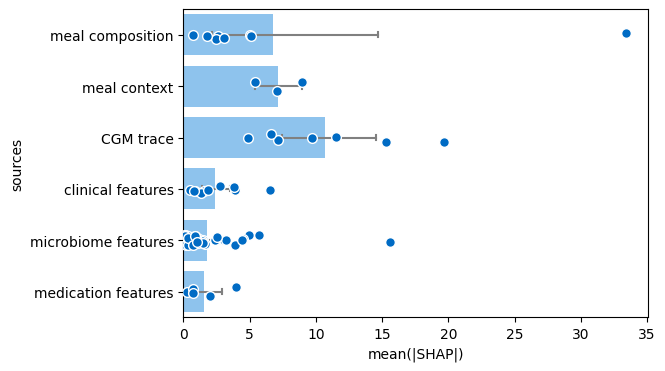

In [529]:
plt.figure(figsize=(6,4))
sns.barplot(data=tmp,x='mean(|SHAP|)',y='sources',capsize=0.1,color='#008BFB',errcolor="grey",linewidth=0.1,alpha=0.5,errwidth=1.5)
sns.stripplot(data=tmp,x='mean(|SHAP|)',y='sources',color='#006BC4',s=7,edgecolor='white',linewidth=1)

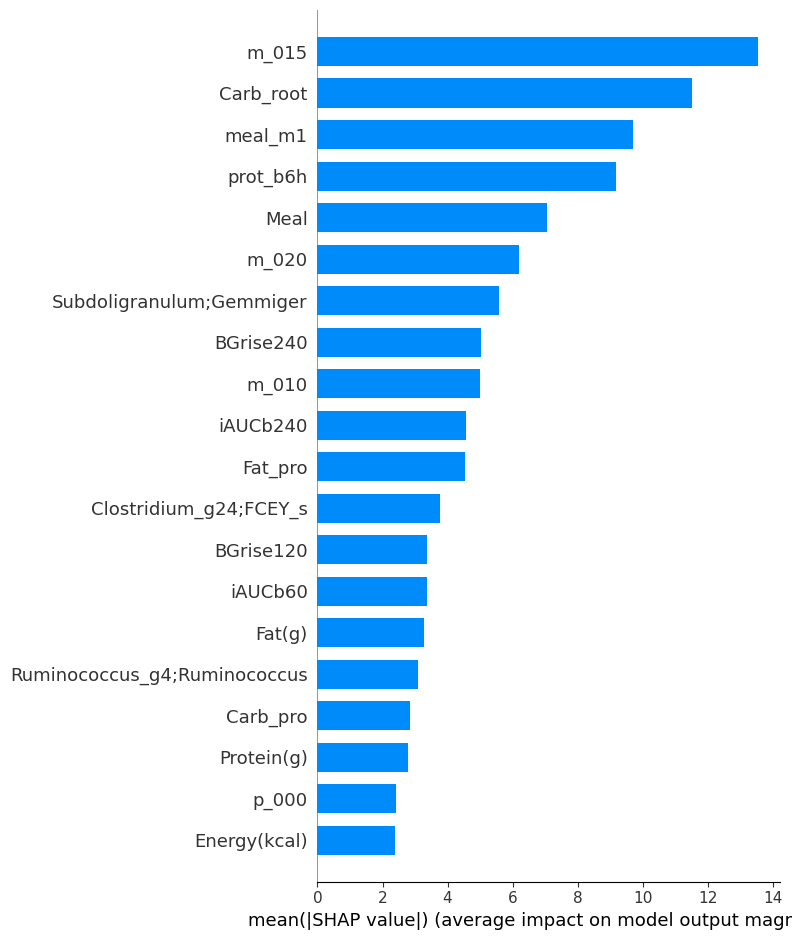

In [66]:
shap.summary_plot(shap_values,X,plot_type='bar')